# Download the data

In [0]:
!wget -qq "https://www.dropbox.com/s/c1pzdacnzhvi6pm/histos_tba.20.npz"

# Load and Pre-process

In [0]:
import numpy as np
from random import shuffle

X = np.load("/content/histos_tba.20.npz")['variables']
y = np.load("/content/histos_tba.20.npz")['parameters'][:,0]

**Shuffle and seperate 10% of the data as test data**

In [0]:
rows = list(range(len(X)))
shuffle(rows)
X = X[rows]
y = y[rows]
X_test = X[int(len(X)*0.9):]
y_test = y[int(len(X)*0.9):]
y = y[:int(len(X)*0.9)]
X = X[:int(len(X)*0.9)]

**Standarize features and remove features with variance zero**

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
X = X[:,scaler.var_>0]
X_test = X_test[:,scaler.var_>0]
print("Shape after removing features with var=0 :",X.shape)

Shape after removing features with var=0 : (2945106, 70)


**Replace nan with zero**

In [0]:
X = np.nan_to_num(X, nan = 0.0)
X_test = np.nan_to_num(X_test, nan = 0.0)

**Target Distribution**

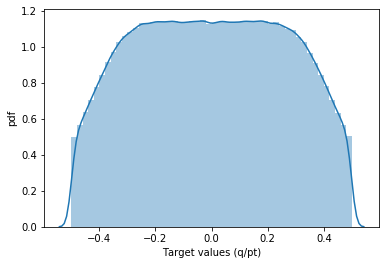

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(y)
plt.xlabel('Target values (q/pt)')
plt.ylabel('pdf')
plt.show()

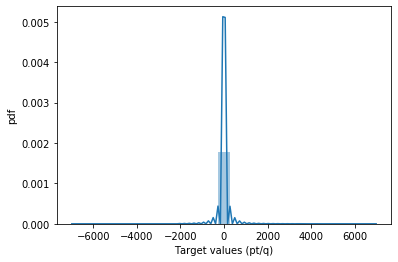

In [7]:
Y = 1/y
sns.distplot(Y)
plt.xlabel('Target values (pt/q)')
plt.ylabel('pdf')
plt.show()

# Model

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

**Set Dropout probability**

In [0]:
p = 0.5

**Dense Neural Network with three dense layers, skip connections and drop out layers**

In [10]:
I = Input(shape=(70))
x = Dense(128,activation='relu')(I)
x_ = Dense(128,activation='relu')(x)
x = x + x_                                ## skip connection
x = Dropout(p)(x)
x_ = Dense(128,activation='relu')(x)
x = x + x_                                ## skip connection
x = Dropout(p)(x)
O = Dense(1)(x)
model = Model(inputs=I, outputs=O)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.compile(optimizer = 'adam', loss='mse', metrics=['mse'] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          9088        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_add (TensorFlowOpLa [(None, 128)]        0           dense[0][0]                      
                                                                 dense_1[0][0]                

# Train, Evaluate and Save

In [12]:
batch_size=128
path = "model.h5"

checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

history = model.fit(x=X, y=y, batch_size=batch_size, epochs=15, verbose=1, validation_split=0.1, callbacks=[checkpoint,early_stop,reduce_lr])

Train on 2650595 samples, validate on 294511 samples
Epoch 1/15
2648960/2650595 [============================>.] - ETA: 0s - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 00001: val_loss improved from -inf to 0.00449, saving model to model.h5
2650595/2650595 [==============================] - 60s 23us/sample - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 2/15
2650496/2650595 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 00002: val_loss improved from 0.00449 to 0.00574, saving model to model.h5
2650595/2650595 [==============================] - 59s 22us/sample - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 3/15
2649344/2650595 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00003: val_loss improved from 0.00574 to 0.00629, saving model to model.h5
2650595/2650595 [======================

In [13]:
model.evaluate(X_test,y_test)

327235/327235 [==============================] - 13s 39us/sample - loss: 0.0059 - mean_squared_error: 0.0059


[0.005930198887898273, 0.0059301974]